# Federal University of Bahia (UFBA)  
## Graduate Program in Geophysics (PPGEOF)  
### Research Group: LIGA - Laboratory of Innovation in Applied Geophysics  

---

**Notebook Title:** *FWI Multiscale*  
**Author:** *Msc Student. Rômulo Barbosa*  
**Advisor:** *Prof.Dr. Peterson Nogueira Santos*  

**Course:** *Master Degree*

**Line of Research:** *Seismic Imaging*  

**Institution:** *Institute of Geosciences – IGEO/UFBA*  
**Date:** *06/10/2025*  

---

### Objectives  
- This tutorial shows an implementation of FWI Multiscale by using Pylops.

---

### Description  

This notebook contains:  

- **Brief summary of what will be done:**  
  - FWI Multiscale using the PyLops library.

- **Data or models used:**  
  - Marmousi true velocity model loaded from binary file (`model-t.bin`)
  - Marmousi inicial velocity model loaded from binary file (`model-inicial.bin`)  

- **Applied methodology:**  
  - Seismic data were generated using the true velocity model with a 2D acoustic wave equation operator (`AcousticWave2D`) from Pylops
  - Ricker wavelets with varying peak frequencies (from 5 Hz to `f_max` Hz)
  - A Wiener filter is applied to filter observed data
  - Objective function applied were L2 Norm


# Importing Libraries

In [1]:
import copy
import numpy as np
from copy import deepcopy
from pylops.utils import *
from FWI import FWI_Multiscale
import matplotlib.pyplot as plt
from devito import configuration
from scipy.ndimage import gaussian_filter
from pylops.waveeqprocessing.twoway import  AcousticWave2D
from utils import (plot_data, Frequency_spectrum, plot_freq_spectrum, create_mask_value)

configuration['log-level'] = 'ERROR'

## Initializing Model Parameters

The foundation of **Pylops** functionality lies in the use of operators, in this case, the 2D acoustic operator (**AcousticWave2D**). This operator wraps **DEVITO** objects, such as SeismicModel, which includes the velocity model, time step (dt), and other details and Geometry, which contains all the necessary geometry information, such as receiver and source coordinates.

By encapsulating these objects, users only need to focus on the parameters to be applied, rather than on how the underlying objects are built.

Below are the parameters required for creating the **AcousticWave2D** operator.

In [2]:
# Modelling parameters (in meters, seconds and Hz)
par = {
    'nx': 369,   'dx': 25.,    'ox': 2,
    'nz': 375,   'dz': 8.,     'oz': 0,
    'ns': 50,    'ds': 175,    'sz': 1,
    'nr': 369,   'dr': 25,     'rz': 1,
    'nt': 5000,  'dt': 0.0008, 't0': 0.,
    'nw': 30,    'freq': 17
}

shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
src_type = 'Ricker' # or 'Ricker_Devito' if you want to use Devito Source
dtype = np.float32
space_order = 32
nbl = 40

In [3]:
# Setting model velocity path
path_true_model="data/model-t.bin"
path_initial_model='data/model-inicial.bin'

# Loading model velocity
vp = (np.fromfile(path_true_model, np.float32)/1000).reshape(par['nx'], par['nz'])
vp0 = (np.fromfile(path_initial_model, np.float32)/1000).reshape(par['nx'], par['nz'])

# Applying water layer
msk = create_mask_value(vp, 1.52)
vp_min = np.min(vp)
vp_max = np.max(vp)

vp0[:, 0:par['nw']] = 1.52
vp[:, 0:par['nw']] = 1.52

# Setting receivers positions
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] # receivers positions
x_r[:, 1] = par['rz']

# Setting source positions
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] # source positions
x_s[:, 1] = par['sz']

# Setting propagation time
tn = (np.arange(par['nt'])*par['dt'])[-1]

# Creating modelling operator
Dop = AcousticWave2D(shape=shape, origin=origin, spacing=spacing, vp=vp*1e3, nbl=nbl, 
                     space_order=space_order,
                    src_x=x_s[:,0], src_z=x_s[:,1], rec_x=x_r[:,0], rec_z=x_r[:,1], t0=par['t0'], tn=tn*1e3,
                     src_type=src_type, f0=par['freq'], dtype=dtype,op_name="fwd", dt=par['dt']*1e3)

vp_true = deepcopy(vp)
vp_init = deepcopy(vp0) 

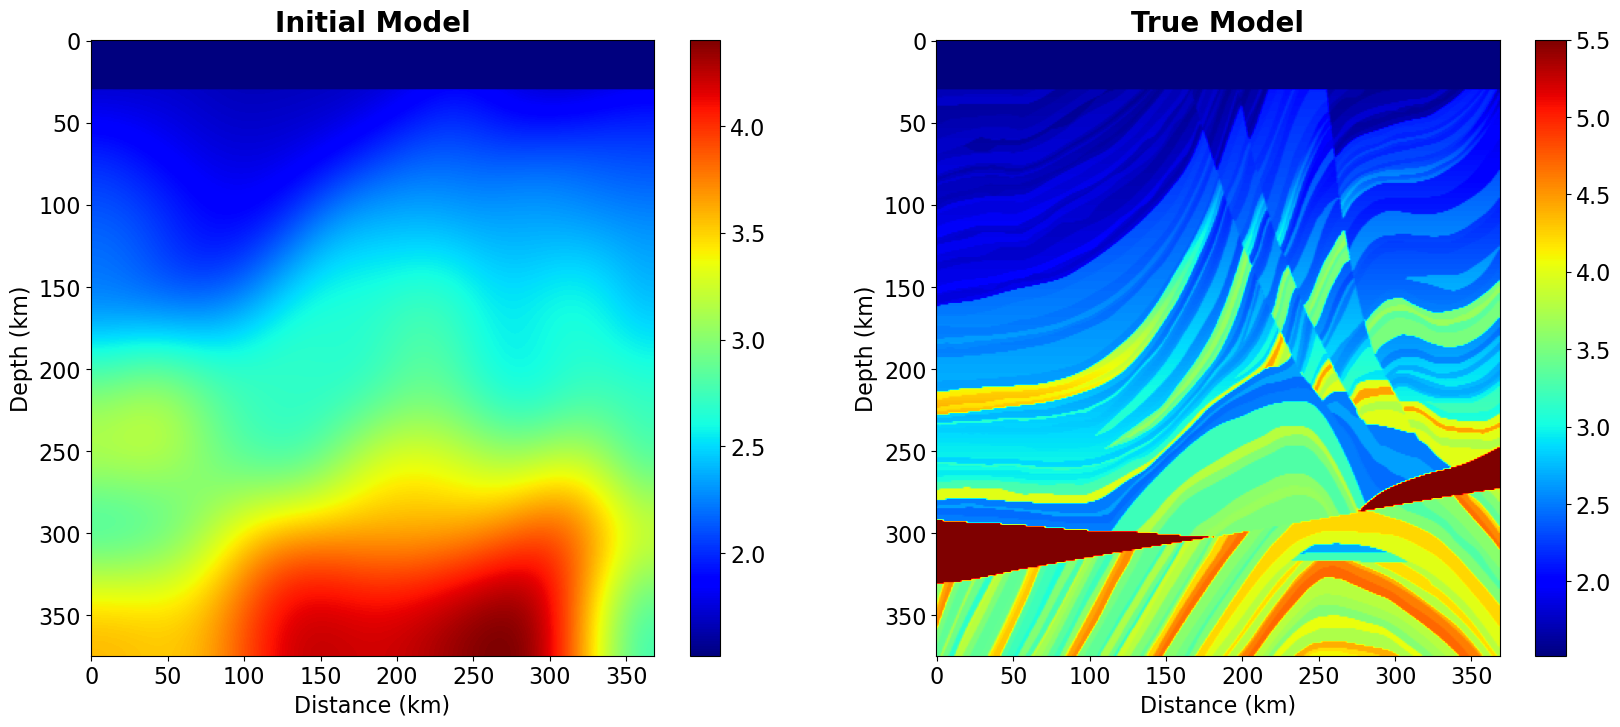

In [4]:
# Plotting velocity models
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(vp_init.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('Initial Model', fontsize=20, fontweight='bold')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(vp_true.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('True Model', fontsize=20, fontweight='bold')
plt.colorbar()

##  Generating Observed Data (Dobs)

Pylops performs forward propagation as follows:

$dobs = Dop * vptrue$, 

where $m$ represents the velocity value $vp$ em m/s.

In [5]:
dobs = Dop * vp_true

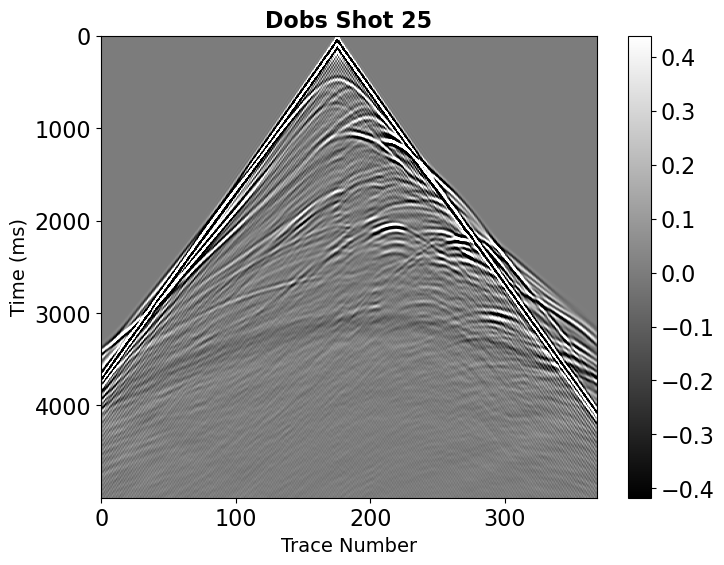

In [6]:
# Plotting Observed Data
shot_dobs = int(par['ns']/2)
plot_data(dobs,shot=shot_dobs, title=f'Dobs Shot {shot_dobs}')

# Spectrum Original Wavelet

Peak Frequency: 17 Hz | Max Frequency: 38 Hz


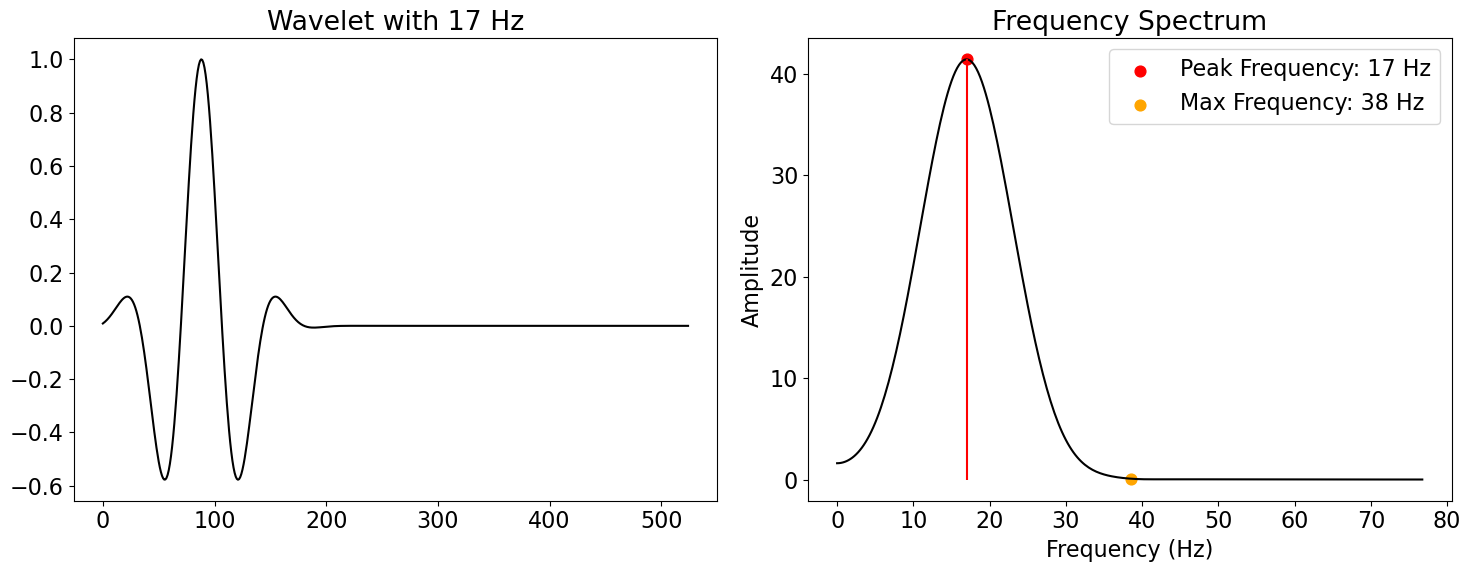

In [7]:
#plotting frequency spectrum for original wavelet
f, amp, f_peak, f_max = Frequency_spectrum(wavelet=Dop.geometry.src.wavelet, dt=par['dt'])

# Multiscale FWI

**Multiscale Full-Waveform Inversion** is a geophysical technique used to refine subsurface models by inverting seismic data. It involves solving the wave equation using both low and high-frequency seismic waves. The process begins with low frequencies, which provide broad but imprecise information about the subsurface. 

As the inversion progresses, higher frequencies are incorporated, refining the model with greater detail. This multiscale approach improves convergence, helps overcome local minima, and enhances the accuracy of subsurface imaging by leveraging different scales of data resolution.

To run FWI Multiscale, you may set some parameters as:

- **ftarg**: Initial frequency to start the multiscale FWI.
- **iterations**: Number of iterations for each frequency.
- **step**: Step size for frequency range increment.
- **vp_min**: Minimum value for the velocity model.
- **vp_max**: Maximum value for the velocity model.
- **water_layer**: Number of layers near the water region that should not be updated during inversion

In [8]:
fwi = FWI_Multiscale(operator=Dop, vp_init=vp_init, dobs=dobs)

vp_inv, fo, dobsfilt = fwi.run(ftarg=2, iterations=30, step=3, vp_min=vp_min, vp_max=vp_max, water_layer=par['nw'],freqs=None)

Working with frequency: 2.0 Hz -> 1/6
Iteration  1
FO:  42957176.259979814

Iteration  2
FO:  35770552.618840665

Iteration  3
FO:  29106610.45242023

Iteration  4
FO:  24823500.427704986

Iteration  5
FO:  19132256.276320953

Iteration  6
FO:  15065023.630838137

Iteration  7
FO:  12202305.64120509

Iteration  8
FO:  10861635.571753927

Iteration  9
FO:  10029933.919238022

Iteration  10
FO:  9418507.39000858

Iteration  11
FO:  4049607.3341140165

Iteration  12
FO:  3277796.631898452

Iteration  13
FO:  5389356.030264078

Iteration  14
FO:  2470443.801139395

Iteration  15
FO:  2227036.660101344

Iteration  16
FO:  2173336.0371251637

Iteration  17
FO:  2033623.814153648

Iteration  18
FO:  1816665.0985974981

Iteration  19
FO:  1592000.9750435692

Iteration  20
FO:  1502847.6667438042

Iteration  21
FO:  1439861.8476831994

Iteration  22
FO:  1407616.6113471251

Iteration  23
FO:  1386509.7719241555

Iteration  24
FO:  1349607.596254114

Iteration  25
FO:  703982.7325088469

Iterati

## Plotting normalized objective function

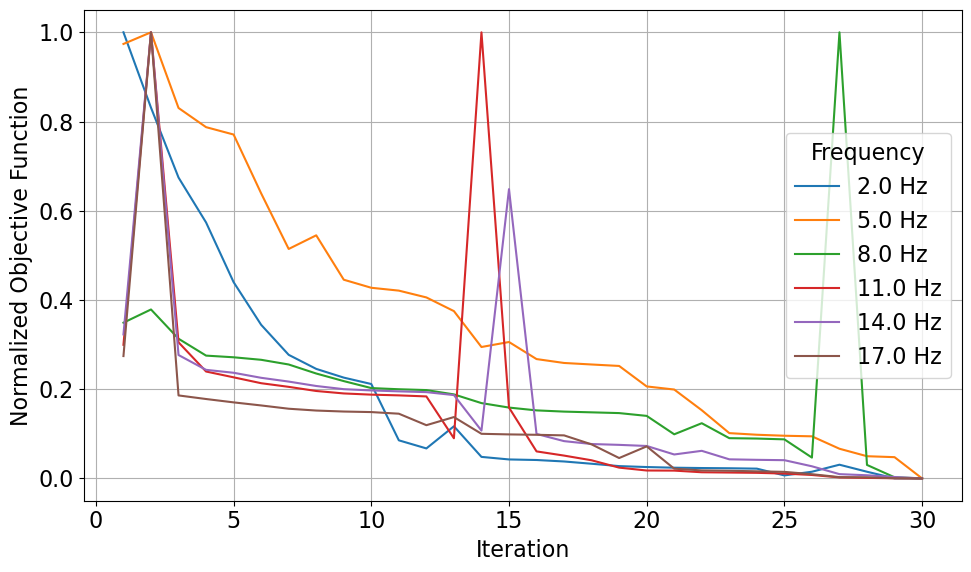

In [9]:
fo_dict_norm = {}

for freq, fo_values in fo.items():
    fo_array = np.array(fo_values)
    fo_min = np.min(fo_array)
    fo_max = np.max(fo_array)
    
    # Evita divisão por zero
    if fo_max - fo_min != 0:
        fo_norm = (fo_array - fo_min) / (fo_max - fo_min)
    else:
        fo_norm = np.zeros_like(fo_array)
    
    fo_dict_norm[freq] = fo_norm


plt.figure(figsize=(10, 6))

for freq, fo_values in fo_dict_norm.items():
    plt.plot(range(1, len(fo_values) + 1), fo_values, label=f'{freq} Hz')

plt.xlabel("Iteration")
plt.ylabel("Normalized Objective Function")
plt.legend(title="Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting inverted velocity model

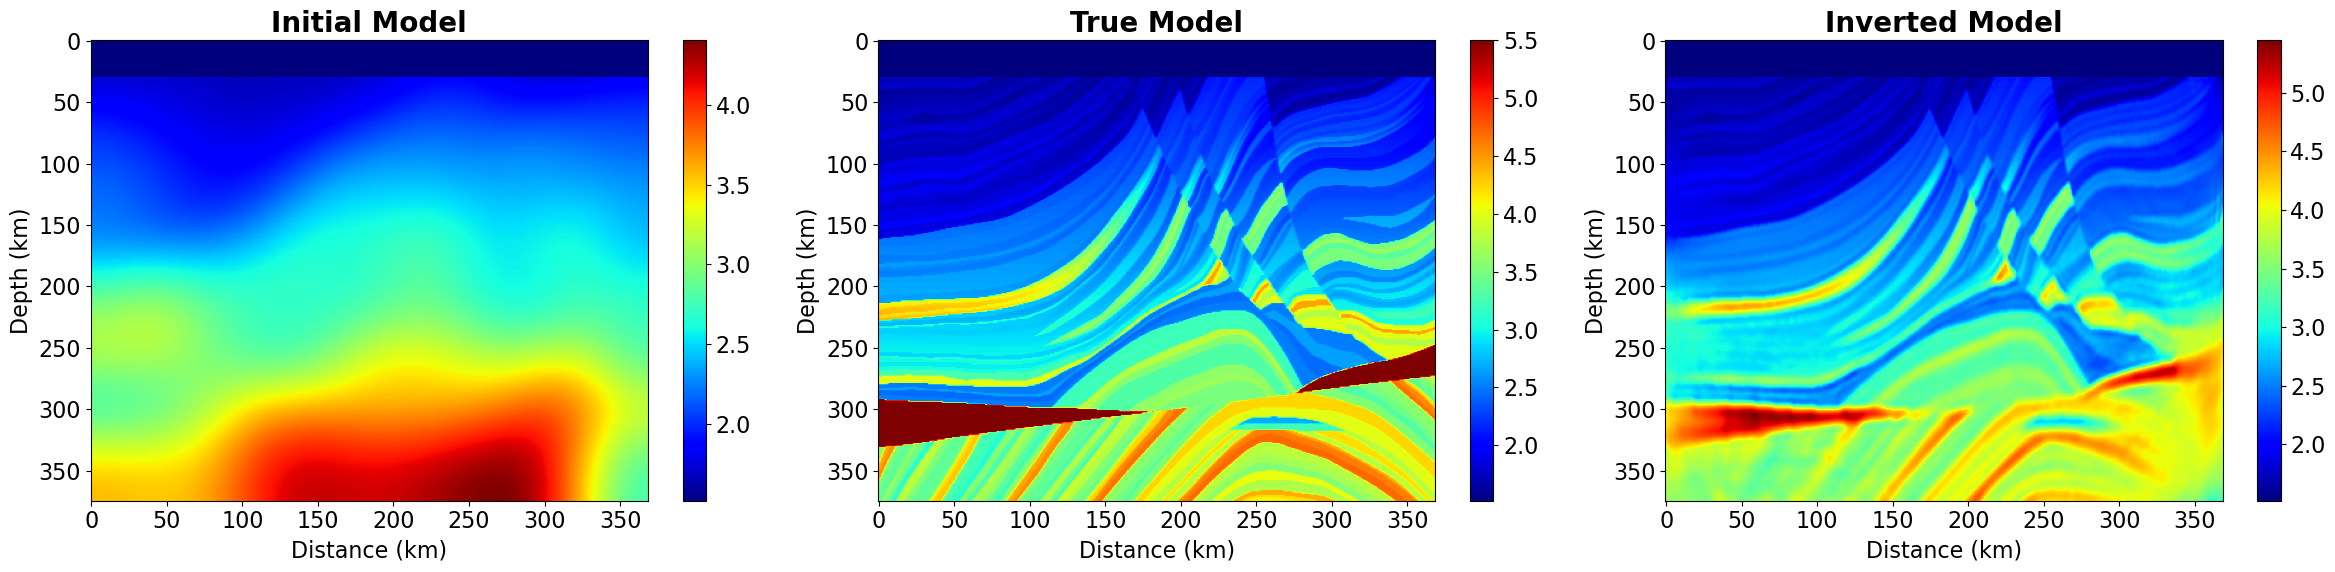

In [10]:
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(vp0.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('Initial Model', fontsize=20, fontweight='bold')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(vp.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('True Model', fontsize=20, fontweight='bold')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(vp_inv.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('Inverted Model', fontsize=20, fontweight='bold')
plt.colorbar()
plt.tight_layout()
# plt.savefig('results_equal_fortran.png', format='png')